In [1]:
!pip install --upgrade pip
!pip install wheel
!pip install camb
!pip install sbi
!pip install torch
!pip install healpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.0 MB/s eta 0:00:0000:010:01
  Attempting uninstall: pip
    Found existing installation: pip 23.3.1
    Uninstalling pip-23.3.1:
      Successfully uninstalled pip-23.3.1
  Using cached camb-1.5.4.tar.gz (1.8 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for camb (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [54 lines of output]
      running bdist_wheel
      running build
      running build_py
      Compiling source...
      /Library/Developer/CommandLineTools/usr/bin/make -C Releaselib --no-print-directory -f../Makefile FORUTILS_SRC_DIR=.. libforutils.a
      gfortran -cpp -ffree-line-length-none -fmax-errors=4 -MMD -fopenmp -fPIC -O3 -MMD -cpp -ffree-line-length-none -fmax-errors=4 -fopenmp -o MiscUtils.o -c ../MiscUtils.f90
      gfortran -cpp -ffree-li

In [3]:
import camb
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import numpy as np
import healpy as hp
from tqdm import tqdm

# Set the parameters for the CAMB simulation
def simulate_cmb_params(params):
    # Create a set of cosmological parameters
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=params[0], ombh2=params[1], omch2=params[2], mnu=params[3], tau=params[4])
    pars.InitPower.set_params(As=params[5], ns=params[6])
    pars.set_for_lmax(1500, lens_potential_accuracy=0)

    # Get the results from CAMB
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    total = powers['total']
    nside = 1024
    cmb_map = hp.sphtfunc.synfast(total[:, 0], nside=nside)
    cl_hat = hp.sphtfunc.anafast(cmb_map)[:2500]

    return cl_hat  # Return the TT spectrum

fiducial_values = [0.674,  0.0224,  0.120, np.log(21), 0.965]

finite_param_steps = [0.0025, 0.0002, 0.0005, np.log(0.5), 0.001]

fiducial_cls = sim(fiducial_values)
def cov_matrix(vals):
    ells = np.arange(2561)[2:2551]
    #V = np.diag(vals**2)*2 / ((2*ells+1))
    V = np.diag(8*np.pi**2*vals**2 / (ells**2*(ells+1)**2*(2*ells+1)))
    return V

def fisher (derivatives, inverse_cov_matrix):
    '''
    A function that calculates the Fisher matrix

    Parameters
    ----------
    derivatives: ndarray
        The 5 point derivative matrix
    inverse_cov_matrix: ndarray
        The inverse covariance matrix

    Returns
    -------
    A Fisher matrix
    '''
    F = np.zeros((5,5))
    for i in range(5):
        for j in range(5):
            d1 = derivatives[i]
            if i != j:
                d2 = derivatives[j]
            else:
                d2 = d1
            term1 = np.dot(d1, np.matmul(inverse_cov_matrix, d2))
            F[i, j] = term1
    return F

def MOPED(obs):
  obs = obs
  d_minus_mu = obs - fiducial_cls
  d_minus_mu_vector = [[i] for i in d_minus_mu ]
  inverse_cov_matrix = np.linalg.inv(cov_matrix(obs))
  term1 = np.matmul(inverse_cov_matrix, d_minus_mu_vector)
  compressed_stat = np.matmul(finite_derivative, term1)

  return compressed_stat



def finite_derivative_calc_update(fiducial_vals, size):
    derivatives = []
    for i in tqdm(range(5)):
        step = size[i]
        parr = fiducial_vals.copy()
        parr[i] = fiducial_vals[i] + step
        parr2 = fiducial_vals.copy()
        parr2[i] = fiducial_vals[i] - step

        cl1 = sim(parr)
        cl2 = sim(parr2)

        derivative = (cl1 - cl2)/(2*step)
        derivatives.append(derivative.tolist())

    return derivatives

finite_derivative = finite_derivative_calc_update(fiducial_values, finite_param_steps)

# Define your parameter space
parameter_min = [60, 0.02, 0.1, 1.8e-9, 0.9]
parameter_max = [80, 0.025, 0.15, 2.5e-9, 1.0]

# Define prior for all parameters
prior = utils.BoxUniform(low=torch.as_tensor(parameter_min),
                         high=torch.as_tensor(parameter_max))

# Define your simulation function
def simulation_wrapper(params):
    return MOPED(simulate_cmb_params(params))

# Your observed parameter values
observed_params = torch.tensor([67.6, 0.0220, 0.122, 2.05e-9, 0.964])

# Generate the observed dataset
observed_dataset = simulation_wrapper(observed_params)

# Run SBI to perform inference
posterior = infer(simulation_wrapper, prior, method='SNPE',
                  num_simulations=2000, num_workers=1)

# Draw samples from the posterior
samples = posterior.sample((1000,), x=observed_dataset)

np.save('sbi_noisy.npy', samples)

# Analyze the results (for example, by plotting the posterior)
limits_plot = [[parameter_min[i], parameter_max[i]] for i in range(len(parameter_min))]
_ = analysis.pairplot(samples, limits=limits_plot,
                      figsize=(10,10))

ModuleNotFoundError: No module named 'camb'

In [9]:
import matplotlib.pyplot as plt
FIG = analysis.pairplot(samples, limits=limits_plot,
                      figsize=(10,10), labels = [r'$H_0$', r'$\Omega_b h^2$', r'$\Omega_c h^2$', r'$\sum m_\nu $'
                      , r'$\tau$', r'$A_s$', r'$n_s$'], offdiag = 'hist', points = observed_params)
plt.savefig('SBI_SNPE_noisy.pdf')

2024-01-24 21:37:23.166038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-24 21:37:23.292293: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-24 21:37:23.292313: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-01-24 21:37:23.953938: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 67 epochs.

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/30100 [00:00<?, ?it/s]

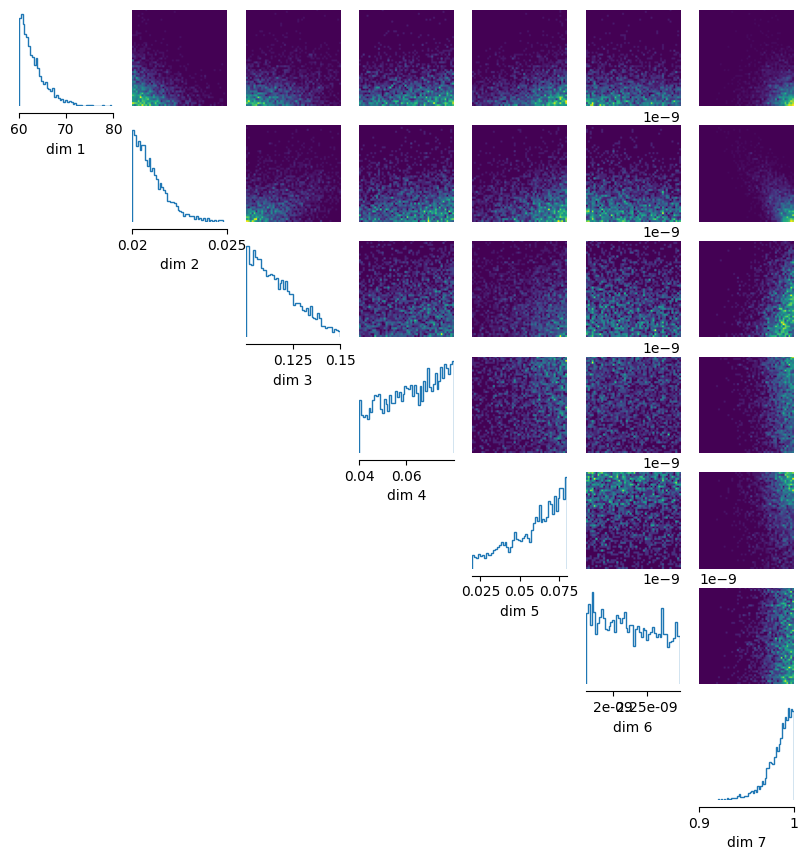

In [3]:
import camb
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

# Set the parameters for the CAMB simulation
def simulate_cmb_params(params):
    # Create a set of cosmological parameters
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=params[0], ombh2=params[1], omch2=params[2], mnu=params[3], tau=params[4])
    pars.InitPower.set_params(As=params[5], ns=params[6])
    pars.set_for_lmax(1500, lens_potential_accuracy=0)

    # Get the results from CAMB
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    total = powers['total']

    return total[:, 0]  # Return the TT spectrum

# Define your parameter space
parameter_min = [60, 0.02, 0.1, 0.04, 0.02, 1.8e-9, 0.9]
parameter_max = [80, 0.025, 0.15, 0.08, 0.08, 2.5e-9, 1.0]

# Define prior for all parameters
prior = utils.BoxUniform(low=torch.as_tensor(parameter_min),
                         high=torch.as_tensor(parameter_max))

# Define your simulation function
def simulation_wrapper(params):
    return simulate_cmb_params(params)

# Your observed parameter values
observed_params = torch.tensor([67.6, 0.0220, 0.122, 0.061, 0.050, 2.05e-9, 0.964])

# Generate the observed dataset
observed_dataset = simulation_wrapper(observed_params)

# Run SBI to perform inference
posterior = infer(simulation_wrapper, prior, method='SNRE',
                  num_simulations=5000, num_workers=1)

# Draw samples from the posterior
samples = posterior.sample((3000,), x=observed_dataset)

# Analyze the results (for example, by plotting the posterior)
limits_plot = [[parameter_min[i], parameter_max[i]] for i in range(len(parameter_min))]
_ = analysis.pairplot(samples, limits=limits_plot,
                      figsize=(10,10))

In [ ]:
print(type(samples))